# Fraud Detection
## Analytics in PySpark

### This notebook presents some data analysis pipelines with PySpark.
### The dataset used in this example is the [Real or Fake] : Fake Job Description Prediction, which can be dowloaded from [Kaggle](https://www.kaggle.com/shivamb/real-or-fake-fake-jobposting-prediction).

#### This notebook uses Python version 3.6 or newer.

Let's start by checking the Python version.

In [1]:
import sys

if int(sys.version[0]) < 3 or int(sys.version[2]) < 6:
    assert("Python version 3.6 or newer is required")

We continue by importing the necessary libraries and toolkits.

In [2]:
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
import pyspark.sql.types as T
import re
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.ml.feature import NGram

%matplotlib inline                                                   

## Data Analysis

### Initialization

Let's load the dataset into a PySpark Dataframe and get started with the data analysis.

In [3]:
spark = SparkSession.builder.appName('Analytics in PySpark').getOrCreate()

dataset_path = './fake_job_postings.csv'

df = spark.read.csv(dataset_path, sep=',', header='true', encoding = 'UTF-8', quote = '\"', escape = '\"');

Let's cache the Dataframe to speed up the computations and print the schema of the data.

In [4]:
df.cache()

df.printSchema()

root
 |-- job_id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- location: string (nullable = true)
 |-- department: string (nullable = true)
 |-- salary_range: string (nullable = true)
 |-- company_profile: string (nullable = true)
 |-- description: string (nullable = true)
 |-- requirements: string (nullable = true)
 |-- benefits: string (nullable = true)
 |-- telecommuting: string (nullable = true)
 |-- has_company_logo: string (nullable = true)
 |-- has_questions: string (nullable = true)
 |-- employment_type: string (nullable = true)
 |-- required_experience: string (nullable = true)
 |-- required_education: string (nullable = true)
 |-- industry: string (nullable = true)
 |-- function: string (nullable = true)
 |-- fraudulent: string (nullable = true)



### Statistics

Let's define two Python functions and two PySpark SQL functions based on the Python functions, which will help with obtaining the maximum and the minimum salary from the data.

In [5]:
def minSalary(s):
    if s != None:
        ss = str(s).split('-')
        if len(ss) == 2:
            s0 = str(s).split('-')[0]
            if s0.isdigit():
                return int(s0)

def maxSalary(s):
    if s != None:
        ss = str(s).split('-')
        if len(ss) == 2:
            s1 = str(s).split('-')[1]
            if s1.isdigit():
                return int(s1)


getMinSalary = F.udf(minSalary, T.IntegerType())

getMaxSalary = F.udf(maxSalary, T.IntegerType())

For all salary ranges in fake job postings, we are going to calculate and print the following statistics:
* Mean value
* Standard deviation
* Median value

In [6]:
df_salary_fake = df.select('job_id', 'salary_range', 'description').filter(df.fraudulent == '1')
df_salary_fake = df_salary_fake.withColumn('min_salary', getMinSalary(df_salary_fake.salary_range))
df_salary_fake = df_salary_fake.withColumn('max_salary', getMaxSalary(df_salary_fake.salary_range))

average = df_salary_fake.agg({'min_salary': 'avg'}).collect()[0][0]
standard_deviation = df_salary_fake.agg({'min_salary': 'stddev'}).collect()[0][0]
median = df_salary_fake.approxQuantile('min_salary', [0.5], 0)[0]

print(f'Mean of the minimum salary in the range in fake job postings: {round(average,2)}')
print(f'Standard deviation of the minimum salary in the range in fake job postings: {round(standard_deviation,2)}')
print(f'Median of the minimum salary in the range in fake job postings: {int(median)}')

print('-'*100)

average = df_salary_fake.agg({'max_salary': 'avg'}).collect()[0][0]
standard_deviation = df_salary_fake.agg({'max_salary': 'stddev'}).collect()[0][0]
median = df_salary_fake.approxQuantile('max_salary', [0.5], 0)[0]

print(f'Mean of the maximum salary in the range in fake job postings: {round(average,2)}')
print(f'Standard deviation of the maximum salary in the range in fake job postings: {round(standard_deviation,2)}')
print(f'Median of the maximum salary in the range in fake job postings: {int(median)}')

Mean of the minimum salary in the range in fake job postings: 66411.11
Standard deviation of the minimum salary in the range in fake job postings: 420676.81
Median of the minimum salary in the range in fake job postings: 30000
----------------------------------------------------------------------------------------------------
Mean of the maximum salary in the range in fake job postings: 159218.71
Standard deviation of the maximum salary in the range in fake job postings: 635164.98
Median of the maximum salary in the range in fake job postings: 45000


For all salary ranges in real job postings, we are going to calculate and print the following statistics:
* Mean value
* Standard deviation
* Median value

In [7]:
df_salary_real = df.select('job_id', 'salary_range', 'description').filter(df.fraudulent == '0')
df_salary_real = df_salary_real.withColumn('min_salary', getMinSalary(df_salary_real.salary_range))
df_salary_real = df_salary_real.withColumn('max_salary', getMaxSalary(df_salary_real.salary_range))

average = df_salary_real.agg({'min_salary': 'avg'}).collect()[0][0]
standard_deviation = df_salary_real.agg({'min_salary': 'stddev'}).collect()[0][0]
median = df_salary_real.approxQuantile('min_salary', [0.5], 0)[0]

print(f'Mean of the minimum salary in the range in real job postings: {round(average,2)}')
print(f'Standard deviation of the minimum salary in the range in real job postings: {round(standard_deviation,2)}')
print(f'Median of the minimum salary in the range in real job postings: {int(median)}')

print(' ')

average = df_salary_real.agg({'max_salary': 'avg'}).collect()[0][0]
standard_deviation = df_salary_real.agg({'max_salary': 'stddev'}).collect()[0][0]
median = df_salary_real.approxQuantile('max_salary', [0.5], 0)[0]

print(f'Mean of the maximum salary in the range in real job postings: {round(average,2)}')
print(f'Standard deviation of the maximum salary in the range in real job postings: {round(standard_deviation,2)}')
print(f'Median of the maximum salary in the range in real job postings: {int(median)}')

Mean of the minimum salary in the range in real job postings: 549247.02
Standard deviation of the minimum salary in the range in real job postings: 18356953.12
Median of the minimum salary in the range in real job postings: 35000
 
Mean of the maximum salary in the range in real job postings: 866568.82
Standard deviation of the maximum salary in the range in real job postings: 28158431.31
Median of the maximum salary in the range in real job postings: 50000


### Outliers

Were the outcomes of the previous cells correct?

The answer is **no**. But why?

Because we did not "clean" our dataset before the statistical analysis.

Let's start the cleaning process by trying to identify outliers in our data.

We are going to use boxplots and distplots for plotting the ranges and the statistics of the salaries in our data.

/mnt/disk/bishop/miniconda3/envs/bd/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/mnt/disk/bishop/miniconda3/envs/bd/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/mnt/disk/bishop/miniconda3/envs/bd/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-leve

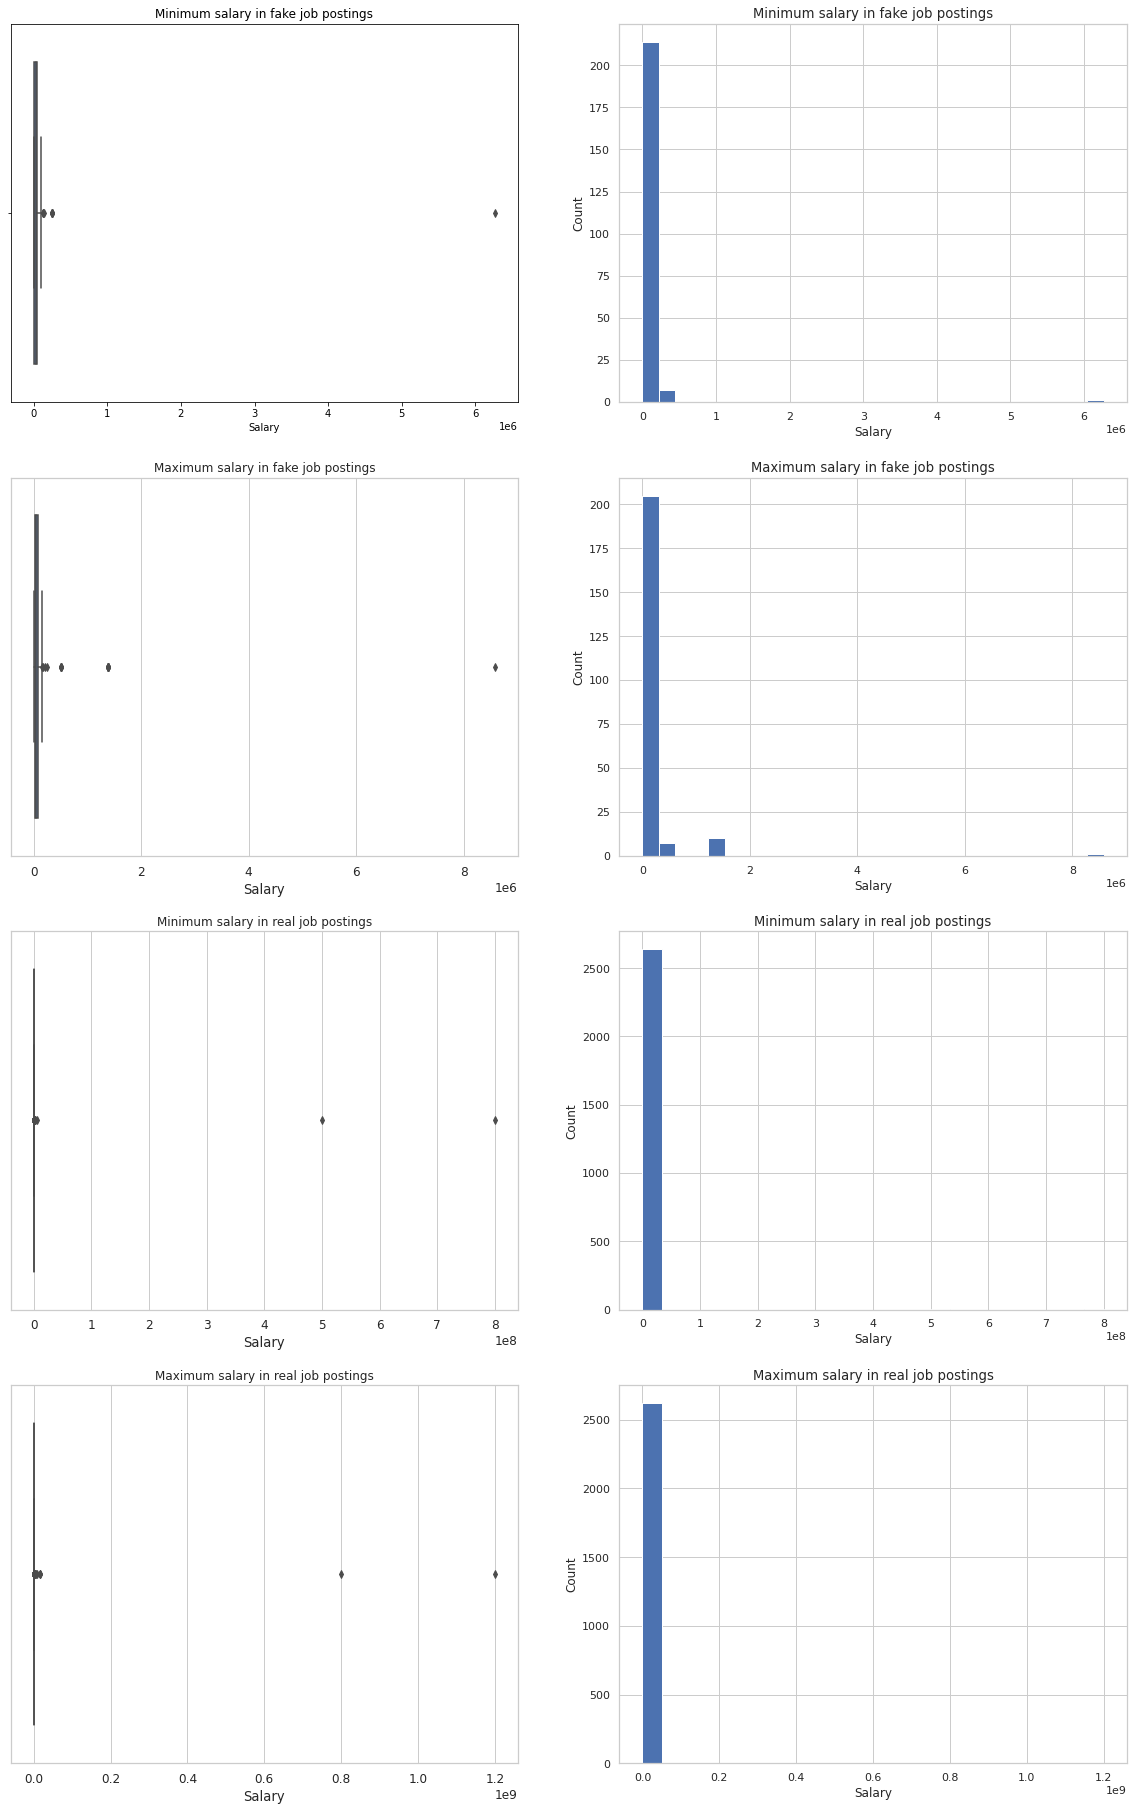

In [8]:
fig, ax = plt.subplots(4, 2, figsize=(20,32))

plt.subplot(4, 2, 1)
df_salary_fake_pd = df_salary_fake.select('min_salary').toPandas()
sns.set(style='whitegrid')
sns.boxplot(
    x='min_salary',
    data=df_salary_fake_pd,
#     showfliers = False
).set(
    xlabel='Salary',
    title='Minimum salary in fake job postings'
)

plt.subplot(4, 2, 2)
df_salary_fake_pd = df_salary_fake.select('min_salary').toPandas()
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
sns.distplot(
    df_salary_fake_pd['min_salary'],
    norm_hist=False,
    kde=False,
    bins=28,
    hist_kws={"alpha": 1}
).set(
    xlabel='Salary',
    ylabel='Count',
    title='Minimum salary in fake job postings'
)

plt.subplot(4, 2, 3)
df_salary_fake_pd = df_salary_fake.select('max_salary').toPandas()
sns.set(style='whitegrid')
sns.boxplot(
    x='max_salary',
    data=df_salary_fake_pd,
#     showfliers = False
).set(
    xlabel='Salary',
    title='Maximum salary in fake job postings'
)

plt.subplot(4, 2, 4)
df_salary_fake_pd = df_salary_fake.select('max_salary').toPandas()
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
sns.distplot(
    df_salary_fake_pd['max_salary'],
    norm_hist=False,
    kde=False,
    bins=28,
    hist_kws={"alpha": 1}
).set(
    xlabel='Salary',
    ylabel='Count',
    title='Maximum salary in fake job postings'
)

plt.subplot(4, 2, 5)
df_salary_real_pd = df_salary_real.select('min_salary').toPandas()
sns.set(style='whitegrid')
sns.boxplot(
    x='min_salary',
    data=df_salary_real_pd,
#     showfliers = False
).set(
    xlabel='Salary',
    title='Minimum salary in real job postings'
)

plt.subplot(4, 2, 6)
df_salary_real_pd = df_salary_real.select('min_salary').toPandas()
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
sns.distplot(
    df_salary_real_pd['min_salary'],
    norm_hist=False,
    kde=False,
    bins=24,
    hist_kws={"alpha": 1}
).set(
    xlabel='Salary',
    ylabel='Count',
    title='Minimum salary in real job postings'
)

plt.subplot(4, 2, 7)
df_salary_real_pd = df_salary_real.select('max_salary').toPandas()
sns.set(style='whitegrid')
sns.boxplot(
    x='max_salary',
    data=df_salary_real_pd,
#     showfliers = False
).set(
    xlabel='Salary',
    title='Maximum salary in real job postings'
)

plt.subplot(4, 2, 8)
df_salary_real_pd = df_salary_real.select('max_salary').toPandas()
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
sns.distplot(
    df_salary_real_pd['max_salary'],
    norm_hist=False,
    kde=False,
    bins=24,
    hist_kws={"alpha": 1}
).set(
    xlabel='Salary',
    ylabel='Count',
    title='Maximum salary in real job postings'
)

#plt.savefig('outlier-detection.png', dpi=300, bbox_inches='tight')
plt.show()

Now, we are going to limit the minimum and maximum values of the salary ranges, in an attempt to remove the outliers, using the 1.5 x IQR rule.

In [9]:
q1q3 = df_salary_fake.approxQuantile('min_salary', [.25,.75], 0)
q1, q3 = q1q3[0], q1q3[1]
iqr = q3 - q1

minminfake = min(q1 - 1.5*iqr, 0)
maxminfake = q3 + 1.5*iqr

q1q3 = df_salary_fake.approxQuantile('max_salary', [.25,.75], 0)
q1, q3 = q1q3[0], q1q3[1]
iqr = q3 - q1

minmaxfake = min(q1 - 1.5*iqr, 0)
maxmaxfake = q3 + 1.5*iqr

q1q3 = df_salary_real.approxQuantile('min_salary', [.25,.75], 0)
q1, q3 = q1q3[0],q1q3[1]
iqr = q3 - q1

minminreal = min(q1 - 1.5*iqr, 0)
maxminreal = q3 + 1.5*iqr

q1q3 = df_salary_real.approxQuantile('max_salary', [.25,.75], 0)
q1, q3 = q1q3[0], q1q3[1]
iqr = q3 - q1

minmaxreal = min(q1 - 1.5*iqr, 0)
maxmaxreal = q3 + 1.5*iqr

Let's see what we achieved through boxplots and distplots.

/mnt/disk/bishop/miniconda3/envs/bd/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/mnt/disk/bishop/miniconda3/envs/bd/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/mnt/disk/bishop/miniconda3/envs/bd/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-leve

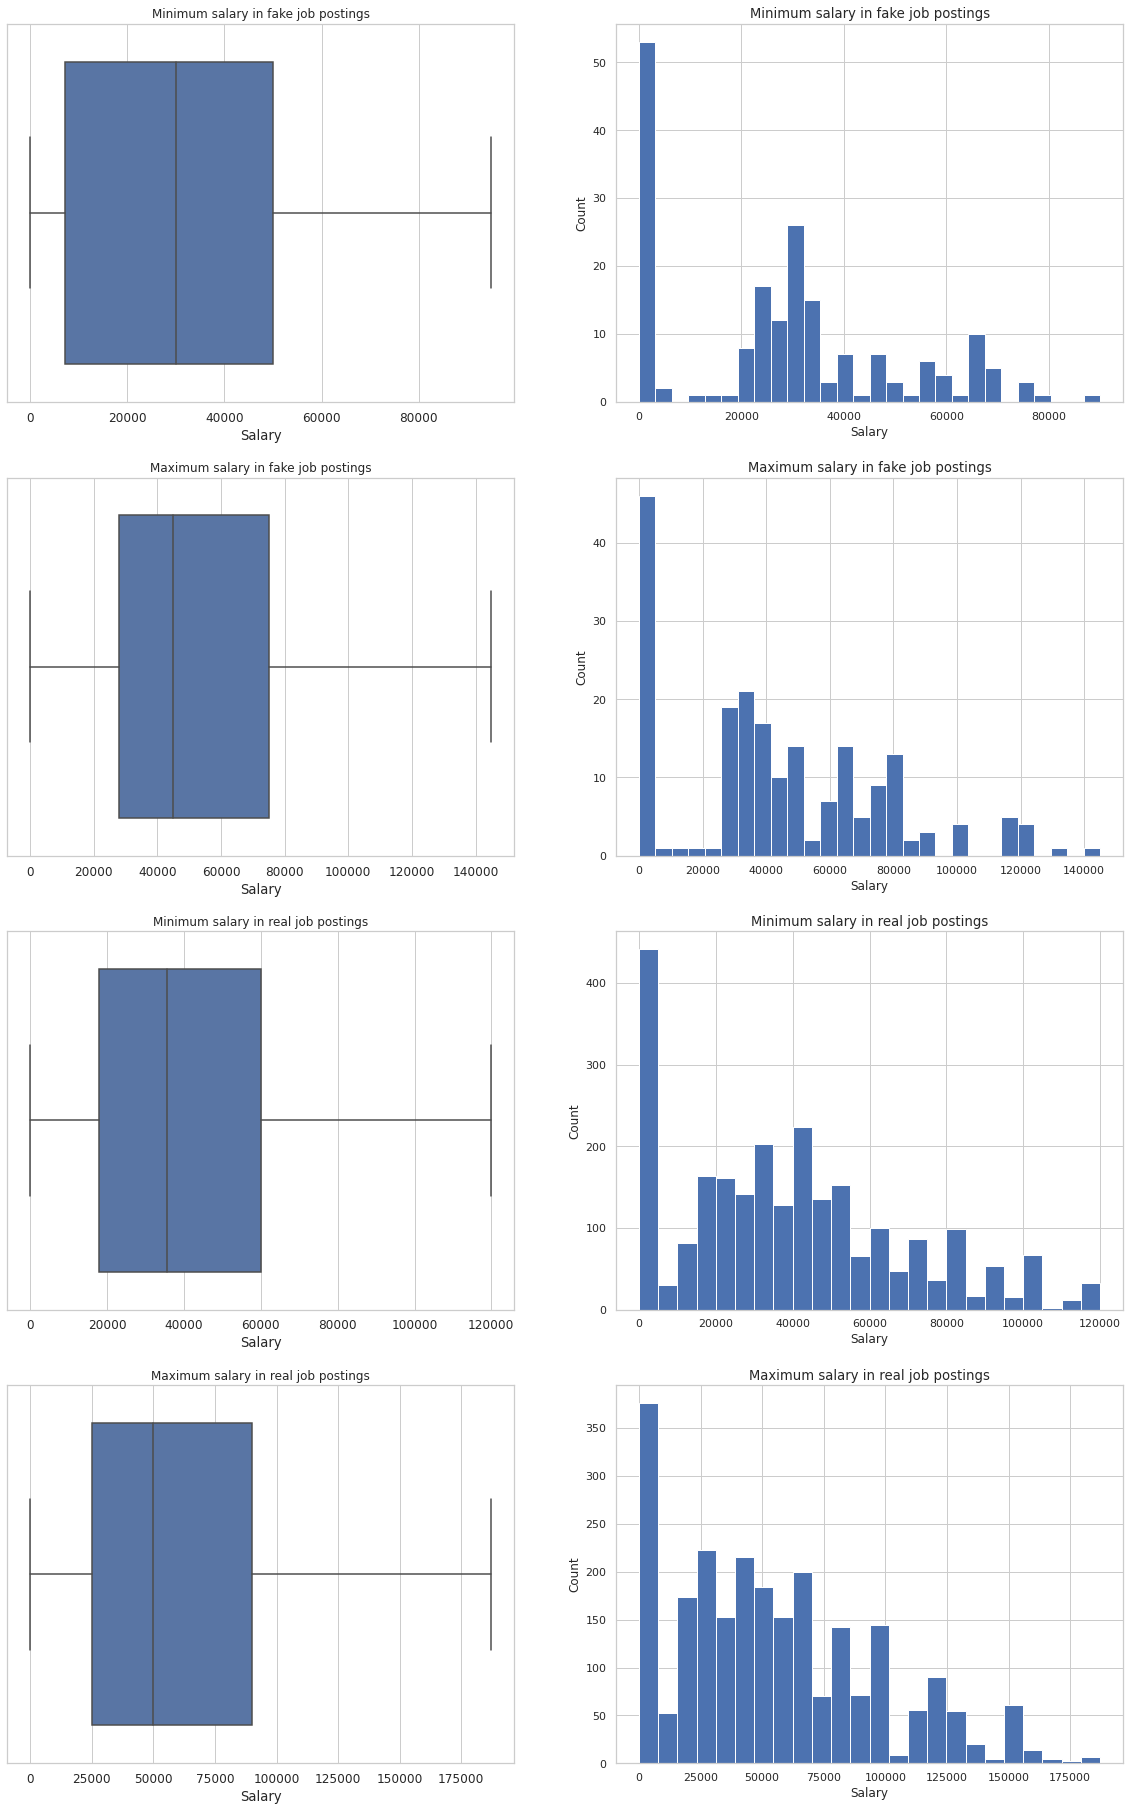

In [10]:
fig, ax = plt.subplots(4, 2, figsize=(20,32))

plt.subplot(4, 2, 1)
df_salary_fake_pd = df_salary_fake.select('min_salary').toPandas()
sns.set(style='whitegrid')
sns.boxplot(
    x='min_salary',
    data=df_salary_fake_pd,
    showfliers = False
).set(
    xlabel='Salary',
    title='Minimum salary in fake job postings'
)

plt.subplot(4, 2, 2)
df_salary_fake_pd = df_salary_fake.select('min_salary').filter((df_salary_fake.min_salary >= minminfake) & (df_salary_fake.max_salary <= maxminfake)).toPandas()
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
sns.distplot(
    df_salary_fake_pd['min_salary'],
    norm_hist=False,
    kde=False,
    bins=28,
    hist_kws={"alpha": 1}
).set(
    xlabel='Salary',
    ylabel='Count',
    title='Minimum salary in fake job postings'
)

plt.subplot(4, 2, 3)
df_salary_fake_pd = df_salary_fake.select('max_salary').toPandas()
sns.set(style='whitegrid')
sns.boxplot(
    x='max_salary',
    data=df_salary_fake_pd,
    showfliers = False
).set(
    xlabel='Salary',
    title='Maximum salary in fake job postings'
)

plt.subplot(4, 2, 4)
df_salary_fake_pd = df_salary_fake.select('max_salary').filter((df_salary_fake.max_salary >= minmaxfake) & (df_salary_fake.max_salary <= maxmaxfake)).toPandas()
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
sns.distplot(
    df_salary_fake_pd['max_salary'],
    norm_hist=False,
    kde=False,
    bins=28,
    hist_kws={"alpha": 1}
).set(
    xlabel='Salary',
    ylabel='Count',
    title='Maximum salary in fake job postings'
)

plt.subplot(4, 2, 5)
df_salary_real_pd = df_salary_real.select('min_salary').toPandas()
sns.set(style='whitegrid')
sns.boxplot(
    x='min_salary',
    data=df_salary_real_pd,
    showfliers = False
).set(
    xlabel='Salary',
    title='Minimum salary in real job postings'
)

plt.subplot(4, 2, 6)
df_salary_real_pd = df_salary_real.select('min_salary').filter((df_salary_real.min_salary >= minminreal) & (df_salary_real.min_salary < maxminreal)).toPandas()
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
sns.distplot(
    df_salary_real_pd['min_salary'],
    norm_hist=False,
    kde=False,
    bins=24,
    hist_kws={"alpha": 1}
).set(
    xlabel='Salary',
    ylabel='Count',
    title='Minimum salary in real job postings'
)

plt.subplot(4, 2, 7)
df_salary_real_pd = df_salary_real.select('max_salary').toPandas()
sns.set(style='whitegrid')
sns.boxplot(
    x='max_salary',
    data=df_salary_real_pd,
    showfliers = False
).set(
    xlabel='Salary',
    title='Maximum salary in real job postings'
)

plt.subplot(4, 2, 8)
df_salary_real_pd = df_salary_real.select('max_salary').filter((df_salary_real.max_salary >= minmaxreal) & (df_salary_real.max_salary < maxmaxreal)).toPandas()
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
sns.distplot(
    df_salary_real_pd['max_salary'],
    norm_hist=False,
    kde=False,
    bins=24,
    hist_kws={"alpha": 1}
).set(
    xlabel='Salary',
    ylabel='Count',
    title='Maximum salary in real job postings'
)

# plt.savefig('output.png', dpi=300, bbox_inches='tight')
plt.show()

Although this 1.5 x IQR rule statistically eliminates outliers, the values left may still have outliers, we can perform a manual search for official data on the web to find ranges as close as possible to the reality.

That being said, an realistic salary range in the US should be **\\$12,000 - \\$260,000**. So, we accept this range as a normal one for our data and proceed with **custom_minimum**=\\$12,000 and **custom_maximum**=\\$260,000.

Let's define two Python functions, which will help with removing the outliers from the dataframe, using the salary outliers we identifies earlier. These functions will perform the following operations:
* Calculate the upper and lower IQR-based bounds
* Flag as outliers the entries whose minimum salaries are either lower than $min(bound_{lower}, \text{custom_minimum})$ or higher than $max(bound_{upper}, \text{custom_maximum})$.

In [11]:
def calculate_bounds(df, cols):
    bounds = {
        c: dict(
            zip(['q1', 'q3'], df.approxQuantile(c, [.25, .75], 0))
        )
        for c,d in zip(df.columns, df.dtypes) if d[0] in cols and d[1] == 'int'
    }

    for c in bounds:
        iqr = bounds[c]['q3'] - bounds[c]['q1']
        bounds[c]['lower'] = bounds[c]['q1'] - (iqr * 1.5)
        bounds[c]['upper'] = bounds[c]['q3'] + (iqr * 1.5)

    return bounds

def flag_outliers(df, cols, custom_mins, custom_maxs):
    bounds = calculate_bounds(df, cols)
    
    for items in zip(cols, custom_mins, custom_maxs):
        col = items[0]
        custom_min = items[1]
        custom_max = items[2]
        
        bounds[col]['lower'] = max(bounds[col]['lower'], custom_min)
        bounds[col]['upper'] = min(bounds[col]['upper'], custom_max)
            
        df = df.withColumn(col+'_outlier',
                           F.when(~F.col(col).
                                  between(bounds[col]['lower'], bounds[col]['upper']),
                                  'yes').otherwise('no'))
    
    return df

Now we are going to apply these functions on the dataframe and remove the outliers.

In [12]:
df_salary_fake = flag_outliers(df_salary_fake, ['min_salary', 'max_salary'], [12000, 12000], [260000, 260000])

df_salary_fake_cleaned = df_salary_fake.filter(df_salary_fake.max_salary_outlier == 'no').filter(df_salary_fake.max_salary_outlier == 'no')

df_salary_real = flag_outliers(df_salary_real, ['min_salary', 'max_salary'], [12000, 12000], [260000, 260000])

df_salary_real_cleaned = df_salary_real.filter(df_salary_real.min_salary_outlier == 'no').filter(df_salary_real.max_salary_outlier == 'no')

For all salary ranges in cleaned fake job postings, we are going to calculate and print the following statistics:
* Mean value
* Standard deviation
* Median value

In [13]:
average = df_salary_fake_cleaned.agg({'min_salary': 'avg'}).collect()[0][0]
standard_deviation = df_salary_fake_cleaned.agg({'min_salary': 'stddev'}).collect()[0][0]
median = df_salary_fake_cleaned.approxQuantile('min_salary', [0.5], 0)[0]

print(f'Mean of the minimum salary in the range in cleaned fake job postings: {round(average,2)}')
print(f'Standard deviation of the minimum salary in the range in cleaned fake job postings: {round(standard_deviation,2)}')
print(f'Median of the minimum salary in the range in cleaned fake job postings: {int(median)}')

print(' ')

average = df_salary_fake_cleaned.agg({'max_salary': 'avg'}).collect()[0][0]
standard_deviation = df_salary_fake_cleaned.agg({'max_salary': 'stddev'}).collect()[0][0]
median = df_salary_fake_cleaned.approxQuantile('max_salary', [0.5], 0)[0]

print(f'Mean of the maximum salary in the range in cleaned fake job postings: {round(average,2)}')
print(f'Standard deviation of the maximum salary in the range in cleaned fake job postings: {round(standard_deviation,2)}')
print(f'Median of the maximum salary in the range in cleaned fake job postings: {int(median)}')

Mean of the minimum salary in the range in cleaned fake job postings: 40716.89
Standard deviation of the minimum salary in the range in cleaned fake job postings: 23539.14
Median of the minimum salary in the range in cleaned fake job postings: 34000
 
Mean of the maximum salary in the range in cleaned fake job postings: 56936.01
Standard deviation of the maximum salary in the range in cleaned fake job postings: 26764.15
Median of the maximum salary in the range in cleaned fake job postings: 50000


For all salary ranges in cleaned real job postings, we are going to calculate and print the following statistics:
* Mean value
* Standard deviation
* Median value

In [14]:
average = df_salary_real_cleaned.agg({'min_salary': 'avg'}).collect()[0][0]
standard_deviation = df_salary_real_cleaned.agg({'min_salary': 'stddev'}).collect()[0][0]
median = df_salary_real_cleaned.approxQuantile('min_salary', [0.5], 0)[0]

print(f'Mean of the minimum salary in the range in cleaned real job postings: {round(average,2)}')
print(f'Standard deviation of the minimum salary in the range in cleaned real job postings: {round(standard_deviation,2)}')
print(f'Median of the minimum salary in the range in cleaned real job postings: {int(median)}')

print(' ')

average = df_salary_real_cleaned.agg({'max_salary': 'avg'}).collect()[0][0]
standard_deviation = df_salary_real_cleaned.agg({'max_salary': 'stddev'}).collect()[0][0]
median = df_salary_real_cleaned.approxQuantile('max_salary', [0.5], 0)[0]

print(f'Mean of the maximum salary in the range in cleaned real job postings: {round(average,2)}')
print(f'Standard deviation of the maximum salary in the range in cleaned real job postings: {round(standard_deviation,2)}')
print(f'Median of the maximum salary in the range in cleaned real job postings: {int(median)}')

Mean of the minimum salary in the range in cleaned real job postings: 46342.03
Standard deviation of the minimum salary in the range in cleaned real job postings: 24595.96
Median of the minimum salary in the range in cleaned real job postings: 40000
 
Mean of the maximum salary in the range in cleaned real job postings: 64332.03
Standard deviation of the maximum salary in the range in cleaned real job postings: 34699.18
Median of the maximum salary in the range in cleaned real job postings: 60000


It is obvious that the cleaned dataset produces different statistics than the original data, which was expected.

### n-grams

Finally, we are going to find the 10 most popular bi-grams and tri-grams (sequence of words) in the description field of the dataset and print them alongside their frequencies.

In order to calculate the desired n-gram sequences, we are going to define some functions which will help with performing the following proceedures:
* convert text to lowercase
* remove non-letter characters
* remove redundant whitespaces
* convert text string to array of words
* compute bi-grams
* compute tri-grams

In [15]:
toLowerCase = F.udf(lambda x : str(x).lower(), T.StringType())

removeNonLetters = F.udf(lambda x : re.sub('[^A-Za-z ]+', '', str(x)), T.StringType())

removeRedundantWhitespaces = F.udf(lambda x : re.sub(' +', ' ', str(x)), T.StringType())

stringToArray = F.udf(lambda x : str(x).split(' '), T.ArrayType(T.StringType()))

bigram = NGram(n=2, inputCol='text_array', outputCol='bi-grams')

trigram = NGram(n=3, inputCol='text_array', outputCol='tri-grams')

Lets perform the actual n-gram operations on the fake job postings.

In [16]:
df_salary_fake = df_salary_fake.withColumn('description', toLowerCase(df_salary_fake.description))

df_salary_fake = df_salary_fake.withColumn('description', removeNonLetters(df_salary_fake.description))

df_salary_fake = df_salary_fake.withColumn('description', removeRedundantWhitespaces(df_salary_fake.description))

df_salary_fake = df_salary_fake.withColumn('text_array', stringToArray(df_salary_fake.description))

df_salary_fake = bigram.transform(df_salary_fake)

df_salary_fake = trigram.transform(dresultsf_salary_fake)


exploded = df_salary_fake.select(F.explode(df_salary_fake['bi-grams']).alias('n-grams'))
topn = exploded.rdd.flatMap(lambda x: x).map(lambda x: (x, 1)).reduceByKey(lambda x, y: x + y).sortBy(lambda x: x[1], ascending = False).take(10)
print("10 most popular bi-grams for for fake job postings and their respective frequencies:")
for n in topn:
    print(n)

print("")

exploded = df_salary_fake.select(F.explode(df_salary_fake['tri-grams']).alias('n-grams'))
topn = exploded.rdd.flatMap(lambda x: x).map(lambda x: (x, 1)).reduceByKey(lambda x, y: x + y).sortBy(lambda x: x[1], ascending = False).take(10)
print("10 most popular tri-grams for for fake job postings and their respective frequencies:")
for n in topn:
    print(n)

NameError: name 'dresultsf_salary_fake' is not defined

Lets perform the actual n-gram operations on the real job postings.

In [ ]:
df_salary_real = df_salary_real.withColumn('description', toLowerCase(df_salary_real.description))

df_salary_real = df_salary_real.withColumn('description', removeNonLetters(df_salary_real.description))

df_salary_real = df_salary_real.withColumn('description', removeRedundantWhitespaces(df_salary_real.description))

df_salary_real = df_salary_real.withColumn('text_array', stringToArray(df_salary_real.description))

df_salary_real = bigram.transform(df_salary_real)

df_salary_real = trigram.transform(df_salary_real)


exploded = df_salary_real.select(F.explode(df_salary_real['bi-grams']).alias('n-grams'))
topn = exploded.rdd.flatMap(lambda x: x).map(lambda x: (x, 1)).reduceByKey(lambda x, y: x + y).sortBy(lambda x: x[1], ascending = False).take(10)
print("10 most popular bi-grams for for real job postings and their respective frequencies:")
for n in topn:
    print(n)

print("")

exploded = df_salary_real.select(F.explode(df_salary_real['tri-grams']).alias('n-grams'))
topn = exploded.rdd.flatMap(lambda x: x).map(lambda x: (x, 1)).reduceByKey(lambda x, y: x + y).sortBy(lambda x: x[1], ascending = False).take(10)
print("10 most popular tri-grams for for real job postings and their respective frequencies:")
for n in topn:
    print(n)

That is all for the data analysis. Next, in a separate Jupyter notebook, we are going to perform machine learning for fake job posting identification, using pure Python.